In [49]:
from pathlib import Path, PurePosixPath
import urllib
from typing import Dict, Optional
from datetime import datetime
import os
import re
# from .types import SceneNode, Scene
# from ..utils import create_logger

# log = create_logger("scenes.parser")

class SceneNode:
	name: str
	type: str
	path: str = ""
	relative_path: str = ""
	resource_path: str = ""
	parent: str = ""
	text: str = ""
	position: int = 0
	body: str = ""
	unique: bool = False
	has_script: bool = False
	script_id: str = ""
	children: list = None
	context_value: str = ""
	tooltip: Optional[str] = None
	resource_uri: Dict = None
	def __repr__(self):
		return f'[node name="{self.name}" type="{self.type}" parent="{str(self.parent)}"]' # children={[", ".join([child.name for child in self.children])]}>)>"
		# return f"<SceneNode(name={self.name}, type={self.type}, path={self.path}, parent={self.parent}, children={[", ".join([child.name for child in self.children])]}>)>"
	def __str__(self, level=0):
		s = "  "*level+repr(self.name)+"\n"
		for child in self.children:
			s += child.__str__(level+1)
		return s
		# return f"<SceneNode(name={self.name}, type={self.type}, path={self.path}, parent={self.parent}, children={[child.name for child in self.children]})>"

	def __init__(self, name, type_):
		self.name = name
		self.type = type_
		self.children = []
		self.resource_uri = {}

	def parse_body(self):
		lines = self.body.split("\n")
		new_lines = []
		for line in lines:
			if line.startswith("tile_data"):
				line = "tile_data = PoolIntArray(...)"
			if line.startswith("unique_name_in_owner = true"):
				self.unique = True
			if line.startswith("script = ExtResource"):
				self.has_script = True
				self.script_id = re.search(r'script = ExtResource\(\s*"?([\w]+)"?\s*\)', line).group(1)
				self.context_value += "hasScript"
			if line != "":
				new_lines.append(line)
		self.body = "\n".join(new_lines)
		content = f"```gdresource\n{self.body}\n```"
		self.tooltip = content

class GDResource:
	path: str
	type: str
	id: str
	uid: str
	body: Optional[str] = None
	index: int = 0
	line: int = 0

	def __init__(self, path, type_, id_, uid, body=None, index=0, line=0):
		self.path = path
		self.type = type_
		self.id = id_
		self.uid = uid
		self.body = body
		self.index = index
		self.line = line

class Scene:
	path: Path = Path()
	res_root_path: Path
	@property
	def res_path(self) -> str:
		return "res://" + str(PurePosixPath(self.path.relative_to(self.res_root_path)))
	title: str = ""
	mtime: int = 0
	root: Optional[SceneNode] = None
	external_resources: Dict = {}
	sub_resources: Dict = {}
	nodes: Dict[str, SceneNode] = {}

	def __init__(self):
		self.external_resources = {}
		self.sub_resources = {}
		self.nodes = {}

	def __repr__(self):
		return f"<Scene(title={self.title}, path={str(self.path)}, nodes={",".join(self.nodes.keys())})>"
		# return f"<Scene(title={self.title}, path={self.path}, mtime={self.mtime}, nodes=\n{',\n'.join(self.nodes.keys())})>"
	
	def __str__(self):
		# return f"Scene: {self.title}\nNodes:\n{',\n'.join([str(node) for node in self.nodes.values()])}"
		return f"Scene: {self.title}\n{str(scene.root)}"

class SceneParser:
	scenes: Dict = {} # shared dictionary across all SceneParser instances
	res_root_path: Path
	def __init__(self, res_root_path: Path = Path(".")):
		self.res_root_path = res_root_path

	def parse_scene(self, path_or_res_uri_str: Path | str) -> Scene:
		if str(path_or_res_uri_str).startswith("res://"):
			path = res_root_path / path_or_res_uri_str[len("res://"):]
		else:
			path = Path(path_or_res_uri_str)

		stats = path.stat()

		if path in self.scenes:
			scene = self.scenes[path]
			if scene.mtime == stats.st_mtime:
				return scene

		scene = Scene()
		scene.path = path
		scene.res_root_path = self.res_root_path
		scene.mtime = stats.st_mtime
		scene.title = path.stem # os.path.basename(path)

		self.scenes[path] = scene

		text = path.read_text()
		
		for match in re.finditer(r'\[ext_resource.*', text):
			line = match.group(0)
			# print("parsing ext_resource: ", line)
			type_ = re.search(r'type="([\w]+)"', line)
			path_ = re.search(r'path="([\w.:/]+)"', line)
			uid = re.search(r'uid="([\w:/]+)"', line)
			id_ = re.search(r' id="?([\w]+)"?', line)

			scene.external_resources[id_.group(1)] = {
				'body': line,
				'path': path_.group(1) if path_ else None,
				'type': type_.group(1) if type_ else None,
				'uid': uid.group(1) if uid else None,
				'id': id_.group(1) if id_ else None,
				'index': match.start(),
				'line': text.count("\n", 0, match.start()) + 1,
			}

		last_resource = None
		for match in re.finditer(r'\[sub_resource.*', text):
			line = match.group(0)
			# print("parsing sub_resource: ", line)
			type_ = re.search(r'type="([\w]+)"', line)
			path_ = re.search(r'path="([\w.:/]+)"', line)
			uid = re.search(r'uid="([\w:/]+)"', line)
			id_ = re.search(r' id="?([\w]+)"?', line)
			resource = {
				'path': path_.group(1) if path_ else None,
				'type': type_.group(1) if type_ else None,
				'uid': uid.group(1) if uid else None,
				'id': id_.group(1) if id_ else None,
				'index': match.start(),
				'line': text.count("\n", 0, match.start()) + 1,
			}
			if last_resource:
				last_resource['body'] = text[last_resource['index']:match.start()].strip()

			scene.sub_resources[id_.group(1)] = resource
			last_resource = resource

		root = ""
		nodes = {}
		last_node = None

		node_regex = re.compile(r'\[node.*')
		for match in re.finditer(node_regex, text):
			line = match.group(0)
			# print("parsing node: ", line)
			name = re.search(r'name="([\w]+)"', line).group(1)
			type_ = re.search(r'type="([\w]+)"', line)
			type_ = type_.group(1) if type_ else "PackedScene"
			parent = re.search(r'parent="([\w\/.]+)"', line)
			parent: Optional[Path] = PurePosixPath(parent.group(1)) if parent else None
			instance = re.search(r'instance=ExtResource\(\s*"?([\w]+)"?\s*\)', line)
			instance = instance.group(1) if instance else None

			_path: PurePosixPath
			relative_path: PurePosixPath

			if parent is None:
				root = name
				_path = PurePosixPath(name)
				relative_path = PurePosixPath()
			elif parent == ".":
				parent = root
				relative_path = PurePosixPath(name)
				_path = parent / name
			else:
				parent = PurePosixPath(root) / parent
				relative_path = parent / name
				_path = parent / name

			if last_node:
				last_node.body = text[last_node.position:match.start()]
				last_node.parse_body()
			if last_resource:
				last_resource['body'] = text[last_resource['index']:match.start()].strip()
				last_resource = None

			node = SceneNode(name, type_)
			node.path = _path
			node.description = type_
			node.relative_path = relative_path
			node.parent = parent
			node.text = match.group(0)
			node.position = match.start()
			node.resource_uri = {
				'scheme': "godot",
				'path': _path,
			}
			scene.nodes[str(_path)] = node

			if instance:
				if instance in scene.external_resources:
					node.tooltip = scene.external_resources[instance]['path']
					node.resource_path = scene.external_resources[instance]['path']
					if Path(node.resource_path).suffix in [".tscn"]:
						node.context_value += "openable"
				node.context_value += "hasResourcePath"
			if str(_path) == root:
				scene.root = node
			if str(parent) in nodes:
				# print(f"appending to `{parent}` child node ({node.position}, {node.path})")
				nodes[str(parent)].children.append(node)
			nodes[str(_path)] = node

			last_node = node

		if last_node:
			last_node.body = text[last_node.position:]
			last_node.parse_body()

		resource_regex = re.compile(r'\[resource\]')
		for match in re.finditer(resource_regex, text):
			if last_resource:
				last_resource['body'] = text[last_resource['index']:match.start()].strip()
				last_resource = None

		return scene

res_root_path = Path(r"..").resolve()
scenes_paths = list((res_root_path / "Assets/UI/TabWidgets").rglob("*.tscn"))
scene_parser = SceneParser(res_root_path)
scenes: Dict[str, Scene] = {}
for scene_path in scenes_paths:
	scene = SceneParser(res_root_path).parse_scene(scene_path)
	scenes[scene.res_path] = scene
	# display(scene)
for scene in scenes.values():
	if "SwitchTabWidget" in [PurePosixPath(scene.root.resource_path).stem, PurePosixPath(scene.res_path).stem]:
		continue
	print(PurePosixPath(scene.res_path).stem, "-->", PurePosixPath(scene.root.resource_path).stem)
# scene: Scene = SceneParser().parse_scene(Path(r"..\Assets\UI\TabWidgets\BakeryTabWidget.tscn"))
# scene: Scene = SceneParser().parse_scene(Path(r"..\Assets\UI\TabWidgets\TabWidget.tscn"))
# scene: Scene = SceneParser().parse_scene(Path(r"..\Assets\UI\TabWidgets\TestScene.tscn"))
# display(scene)
# print(str(scene))
# for node in scene.nodes.values():
# 	print(f"Node: {node.name}")
# 	print(str(node))
	# for child in node.children:
	# 	print("  ", child.name)
	# print(node.children)

BakeryTabWidget --> ProductionMenuTabWidget
BarracksTabWidget --> ProductionMenuTabWidget
BathTabWidget --> ProductionMenuTabWidget
BlenderTabWidget --> ProductionMenuTabWidget
BoatBuilderTabWidget --> ProductionMenuTabWidget
BreweryTabWidget --> ProductionMenuTabWidget
BrickyardTabWidget --> ProductionMenuTabWidget
BuildingMenuTabWidget --> TabWidget
BuildMenuByCategoryTabBody4 --> TabWidget2
BuildMenuByCategoryTabWidget --> 
ButcheryTabWidget --> ProductionMenuTabWidget
CannonFoundryTabWidget --> ProductionMenuTabWidget
ChapelTabWidget --> ProductionMenuTabWidget
CharcoalBurningTabWidget --> ProductionMenuTabWidget
ClayPitTabWidget --> ProductionMenuTabWidget
DistilleryTabWidget --> ProductionMenuTabWidget
DoctorTabWidget --> ProductionMenuTabWidget
FarmTabWidget --> ProductionWithRelatedBuildingsMenuTabWidget
FireStationTabWidget --> ProductionMenuTabWidget
FishermanTabWidget --> ProductionMenuTabWidget
HunterTabWidget --> ProductionMenuTabWidget
LookoutTabWidget --> ProductionMenuT

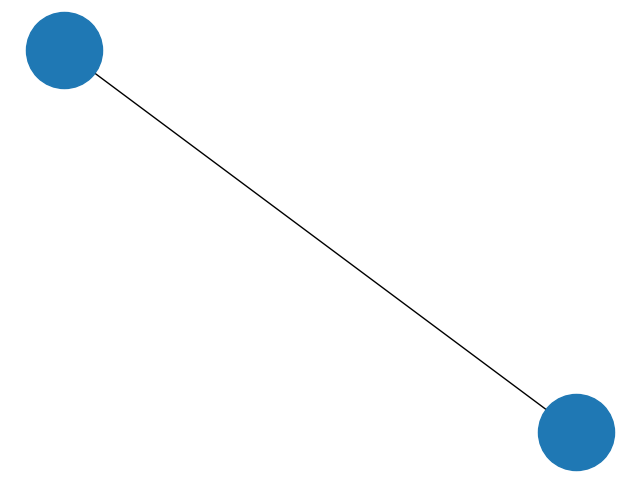

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_edge("foo", "boo")  # explicit two-node form
# G.add_edges_from([(1, 2)])  # add edges from iterable container

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=False, node_size=3000, font_size=16)

# Add labels to the nodes
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=16)

# Show the plot
plt.axis('off')
plt.show()